# Simulate data with SERGIO

This notebook was run in a virtual environment that had `Python 3.9.21` and the following packages with specific versions:  
    - `numpy==1.19.5`  
    - `scipy==1.5.4`  
    - `networkx==2.5`  
    - `pandas==1.1.5`  
    - `sklearn==0.24.2`  
    - `matplotlib==3.3.4`
    
The custom files used to simulate the data (e.g. network structure, transition probabilities, master regulator activity etc) are in the `files_for_SERGIO/` folder.  
Please consult the documentation and GitHub page for SERGIO on how to set it up:  
`https://github.com/PayamDiba/SERGIO`  

#### Simulate clean data first:

In [ ]:
import numpy as np
import pandas as pd
from SERGIO.sergio import sergio
np.random.seed(123)

In [2]:
df = pd.read_csv('files_for_SERGIO/bMat_cID_SERGIO.txt', sep='\t', header=None, index_col=None)
bMat = df.values

sim = sergio(number_genes=200, number_bins = 5, number_sc = 400, noise_params = 0.2, decays=0.8, sampling_state = 1, noise_params_splice = 0.07, noise_type='dpd', dynamics=True, bifurcation_matrix= bMat)
sim.build_graph(input_file_taregts ='files_for_SERGIO/Interaction_cID_SERGIO.txt', input_file_regs='files_for_SERGIO/Regs_cID_SERGIO.txt', shared_coop_state=2)
sim.simulate_dynamics()
exprU, exprS = sim.getExpressions_dynamics()

Start simulating new cell type
binID: 0
number of initial cells: 14
Done with current cell type
Start simulating new cell type
binID: 4
number of initial cells: 60
Done with current cell type
Start simulating new cell type
binID: 3
number of initial cells: 60
Done with current cell type
Start simulating new cell type
binID: 2
number of initial cells: 60
Done with current cell type
Start simulating new cell type
binID: 1
number of initial cells: 60
Done with current cell type


(2000, 2)


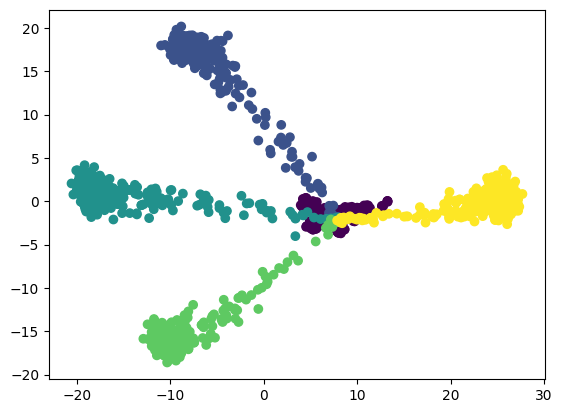

(2000, 2)


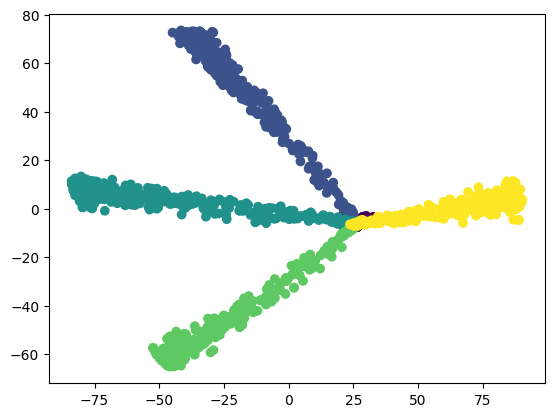

In [3]:
# Turn (5,200,400) into (200,2000):
exprU_clean = np.concatenate(exprU, axis = 1)
exprS_clean = np.concatenate(exprS, axis = 1)

# Create cell type labels:
labels=[0]*400+[1]*400+[2]*400+[3]*400+[4]*400

# Visualize PCA (Unspliced):
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
sergio_pca=pca.fit_transform(np.transpose(exprU_clean))
print(sergio_pca.shape)

# Plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sergio_pca[:,0], sergio_pca[:,1],c=labels,cmap="viridis")
plt.show()



# Visualize PCA (Spliced):
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
sergio_pca=pca.fit_transform(np.transpose(exprS_clean))
print(sergio_pca.shape)

# Plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sergio_pca[:,0], sergio_pca[:,1],c=labels,cmap="viridis")
plt.show()

#### Add some technical noise:

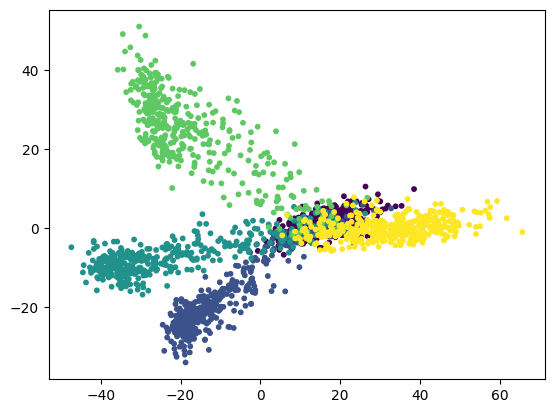

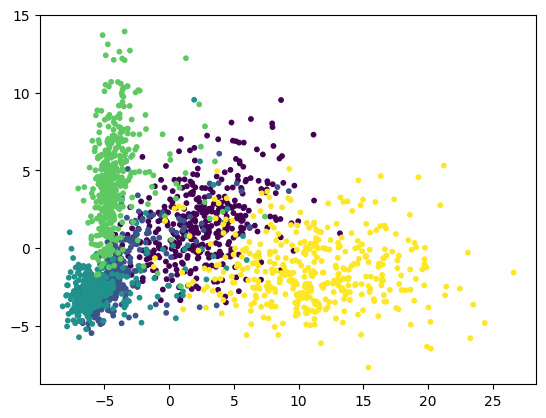

In [4]:
"""
Add outlier genes
"""
exprU_O, exprS_O = sim.outlier_effect_dynamics(exprU, exprS, outlier_prob = 0.01, mean = 0.8, scale = 1)

"""
Add Library Size Effect
"""
libFactor, exprU_O_L, exprS_O_L = sim.lib_size_effect_dynamics(exprU_O, exprS_O, mean = 6.8, scale = 0.15) #4.6, 0.4

"""
Add Dropouts
"""
binary_indU, binary_indS = sim.dropout_indicator_dynamics(exprU_O_L, exprS_O_L, shape = 7.0, percentile = 40) #6.5, 82
exprU_O_L_D = np.multiply(binary_indU, exprU_O_L)
exprS_O_L_D = np.multiply(binary_indS, exprS_O_L)

"""
Convert to UMI count
"""
count_matrix_U, count_matrix_S = sim.convert_to_UMIcounts_dynamics(exprU_O_L_D, exprS_O_L_D)

"""
Make 2d spliced and unspliced expression matrices
"""
count_matrix_U_noisy = np.concatenate(count_matrix_U, axis = 1)
count_matrix_S_noisy = np.concatenate(count_matrix_S, axis = 1)

# Visualize the noisy data:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca=PCA(n_components=2)
sergio_pca=pca.fit_transform(np.transpose(count_matrix_S_noisy))

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sergio_pca[:,0], sergio_pca[:,1],c=labels,cmap="viridis", s=10)
plt.show()

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca=PCA(n_components=2)
sergio_pca=pca.fit_transform(np.transpose(count_matrix_U_noisy))

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sergio_pca[:,0], sergio_pca[:,1],c=labels,cmap="viridis", s=10)
plt.show()

In [5]:
np.save("SERGIO_exprU_noisy.npy", count_matrix_U_noisy)
np.save("SERGIO_exprS_noisy.npy", count_matrix_S_noisy)